In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline
%load_ext pycodestyle_magic

Using TensorFlow backend.


In [2]:
%ls ../wheather_data/

ls: ../wheather_data/: No such file or directory


In [4]:
%cd ../weather_data/
v1 = pd.read_csv('../weather_data/v1_obfs.csv')


/Users/MD/time_series_clustering/weather_data


In [5]:
v = [v1]
v_names = ['v1']
sel_columns = [' Meas_11']
sel_column = [' Meas_11']

### Functions

In [6]:
def sliding_window(data, train_size, test_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    x, y = [], []
    line_size = data.shape[0]
    for start in range(0, line_size, step_size):
        stop = start + train_test_size
        if stop <= line_size:
            x.append(data[start: start+train_size])
            y.append(data[start+train_size: start+train_size+test_size])
    return np.array(x), np.array(y)


def norm_ts(data):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def naive_prediction_mae(x_test, y_test):
    """prediction using last value"""
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None


def model_mae(model, x_test, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


def model_mae_2_naive(model, x_test, x_test_original, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae_2_naive = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae = np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
        naive = np.mean(np.abs(x_test_original[i, -1] - y_test[i, :]))
        mae_2_naive += mae / naive
    mae_2_naive /= n
    print ('current model / naive = {0:0.4f}'.format(mae_2_naive))
    return None


### Parameters of Sliding Window

In [7]:
train_size = 168
test_size = 24
train_test_size = train_size + test_size
# line_size = v1.shape[1]
step_size = 1
train_test_split = int(.75 * v1.shape[0])

### Normalization

In [8]:
data= v1[sel_column].values

train_xy = data[:train_test_split]

test_xy = data[train_test_split:]

train_xy_normed, scaler = norm_ts(train_xy)


train_x, train_y = sliding_window(data=train_xy_normed,
                                  train_size=train_size,
                                  test_size=test_size,
                                  step_size=step_size)

test_x_original, test_y_original = sliding_window(data=np.squeeze(test_xy),
                                  train_size=train_size,
                                  test_size=test_size,
                                  step_size=step_size)


test_x, scaler_test = norm_ts(test_x_original.T)
test_x = test_x.T

train_x, test_x = train_test_reshape(train_x, test_x)
print (train_x.shape, test_x.shape, test_y_original.shape)

(6373, 168, 1) (1998, 168, 1) (1998, 24)


### CNN network

In [9]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=train_size):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [10]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4461 samples, validate on 1912 samples
Epoch 1/20
 - 1s - loss: 0.0141 - mean_absolute_error: 0.0907 - val_loss: 0.0144 - val_mean_absolute_error: 0.0908
Epoch 2/20
 - 1s - loss: 0.0065 - mean_absolute_error: 0.0627 - val_loss: 0.0115 - val_mean_absolute_error: 0.0802
Epoch 3/20
 - 1s - loss: 0.0057 - mean_absolute_error: 0.0584 - val_loss: 0.0104 - val_mean_absolute_error: 0.0757
Epoch 4/20
 - 1s - loss: 0.0053 - mean_absolute_error: 0.0557 - val_loss: 0.0097 - val_mean_absolute_error: 0.0725
Epoch 5/20
 - 1s - loss: 0.0049 - mean_absolute_error: 0.0535 - val_loss: 0.0092 - val_mean_absolute_error: 0.0700
Epoch 6/20
 - 1s - loss: 0.0046 - mean_absolute_error: 0.0517 - val_loss: 0.0088 - val_mean_absolute_error: 0.0678
Epoch 7/20
 - 1s - loss: 0.0044 - mean_absolute_error: 0.0500 - val_loss: 0.0084 - val_mean_absolute_error: 0.0661
Epoch 8/20
 - 1s - loss: 0.

### Comparison to Naive model

In [11]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)
model_mae_2_naive(model,
                  x_test=test_x,
                  x_test_original=test_x_original,
                  y_test = test_y_original,
                  scaler=scaler_test,
                  inv_norm=True)

naive model = 31.0674
current model = 24.1911
current model / naive = 0.8412


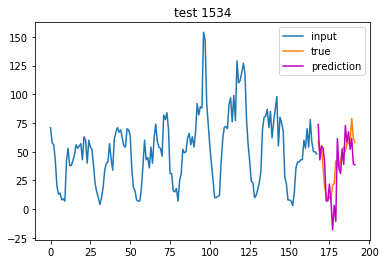

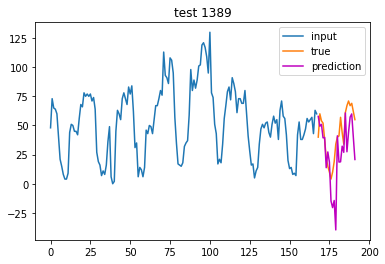

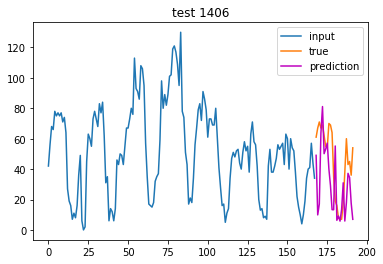

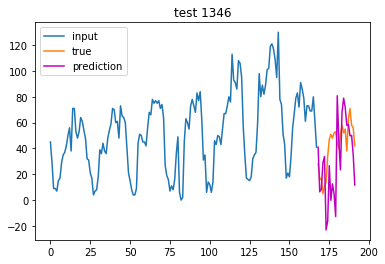

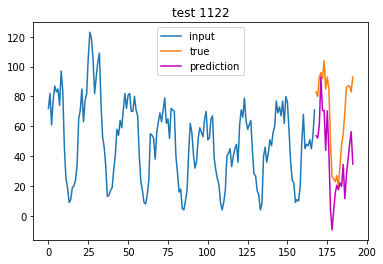

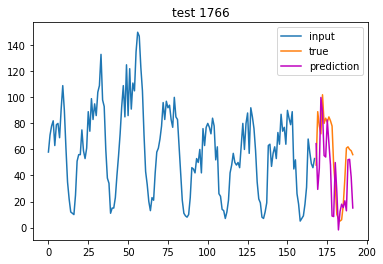

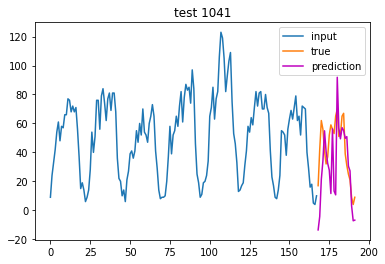

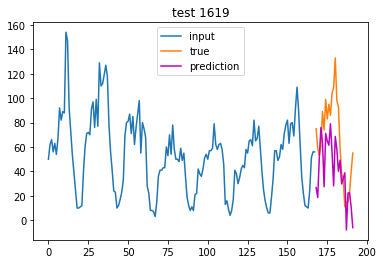

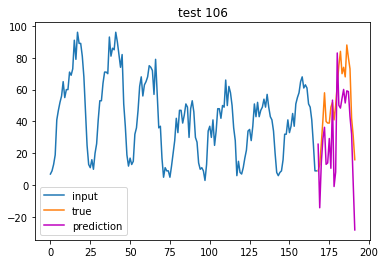

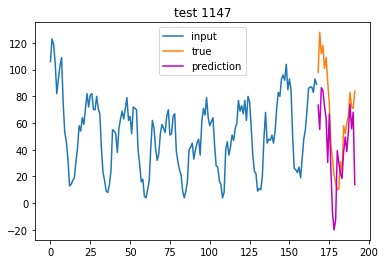

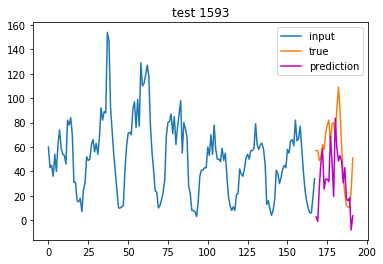

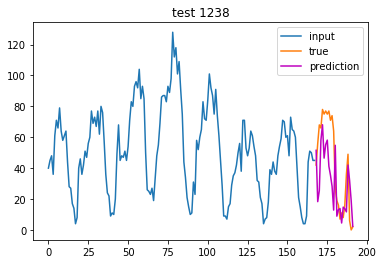

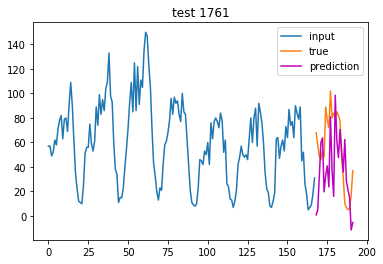

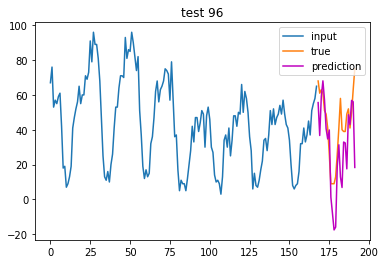

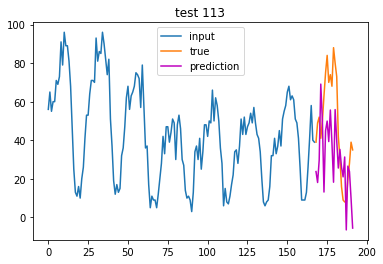

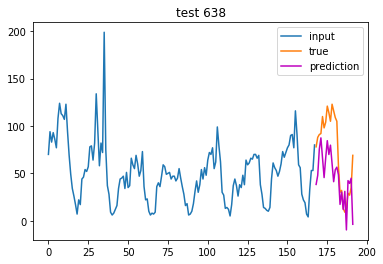

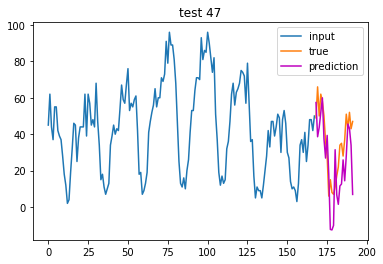

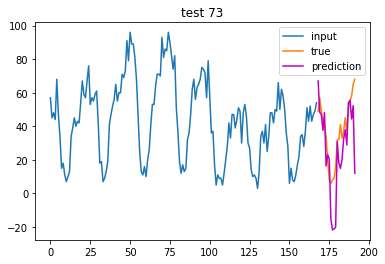

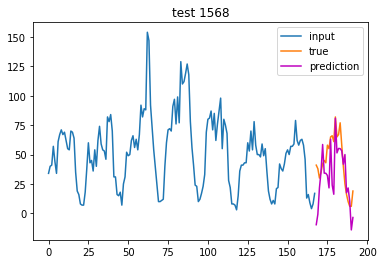

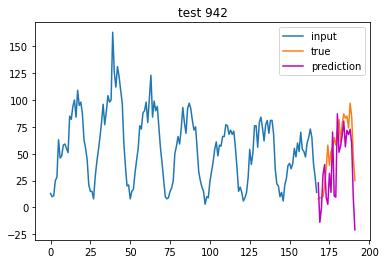

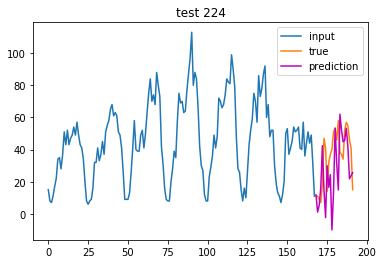

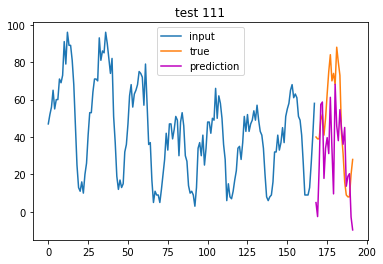

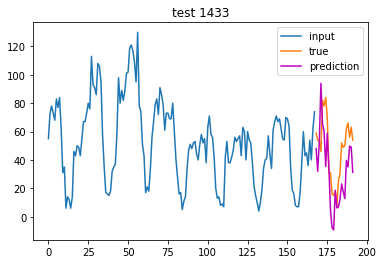

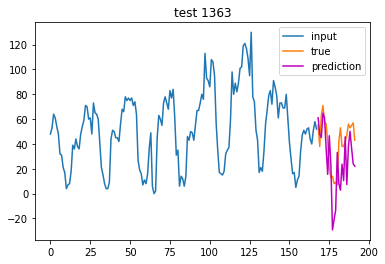

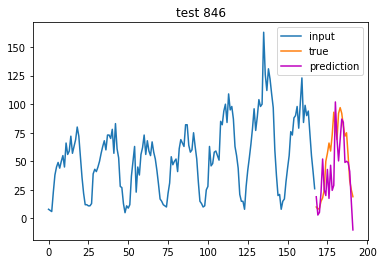

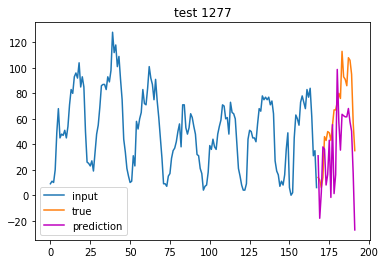

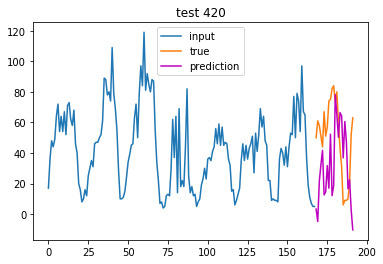

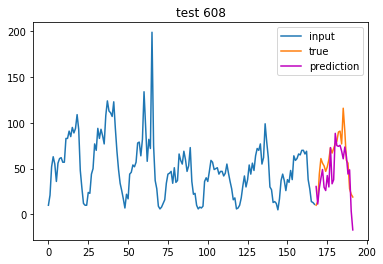

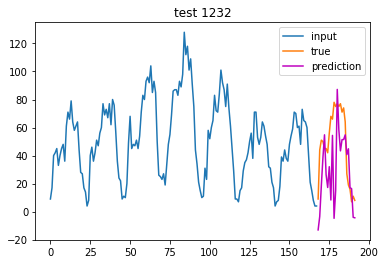

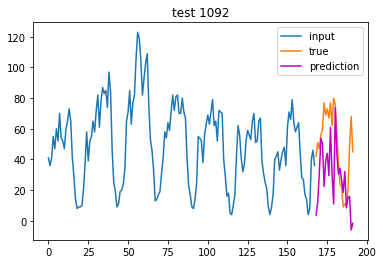

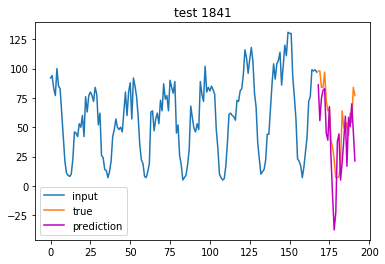

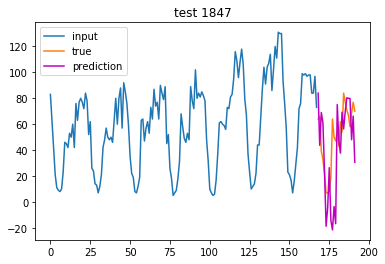

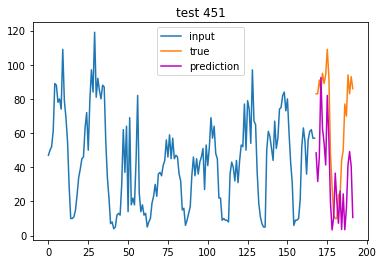

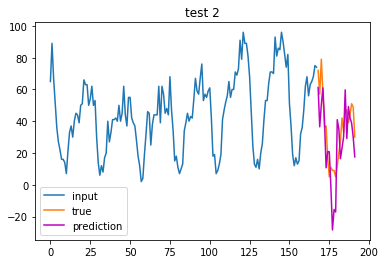

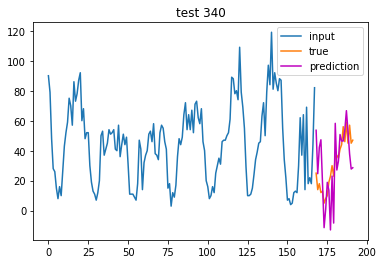

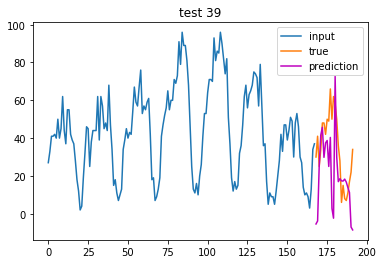

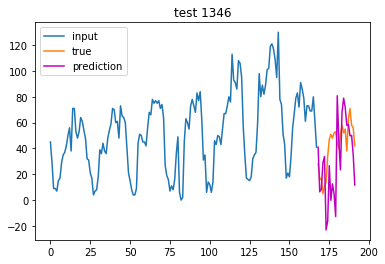

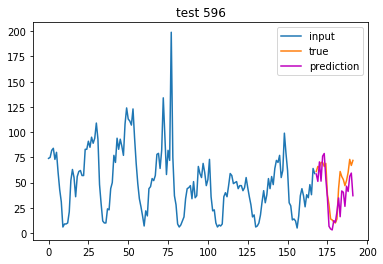

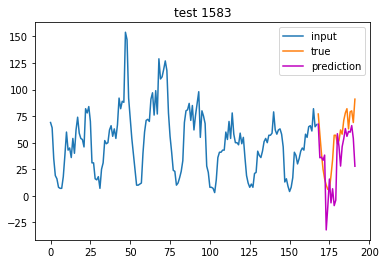

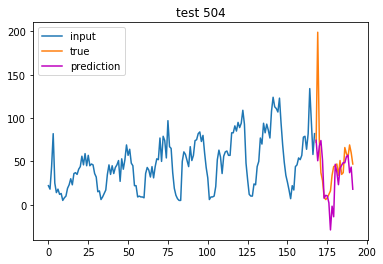

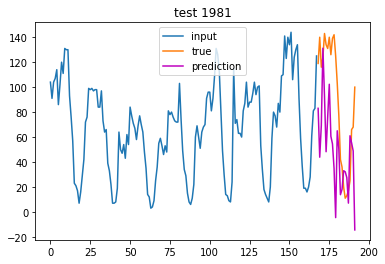

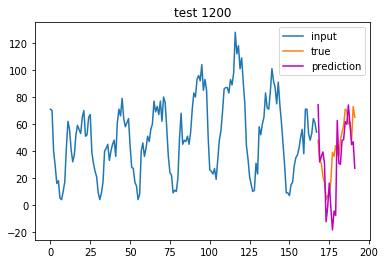

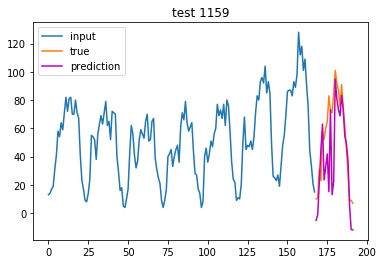

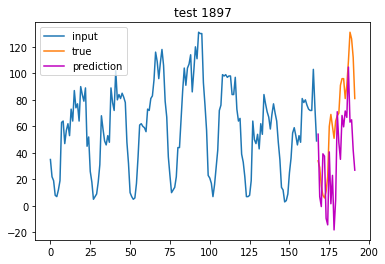

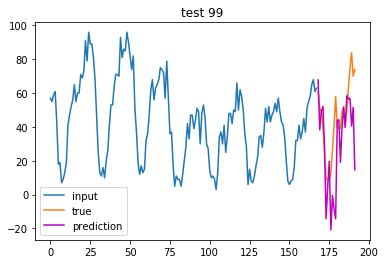

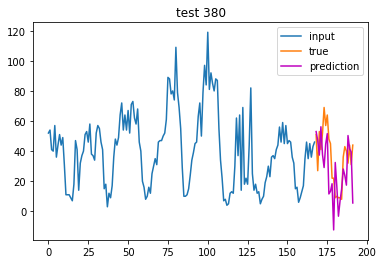

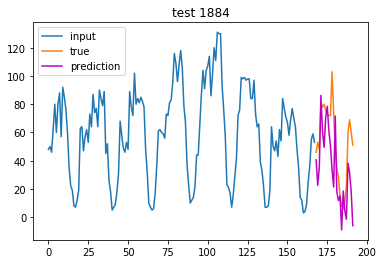

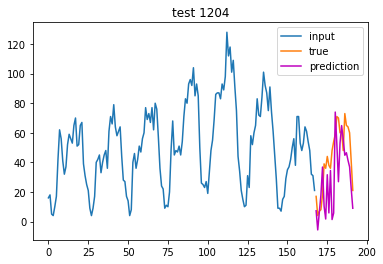

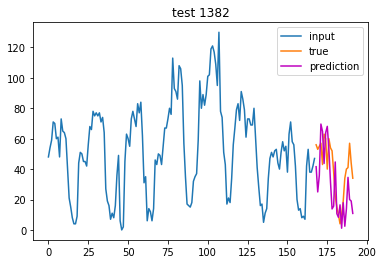

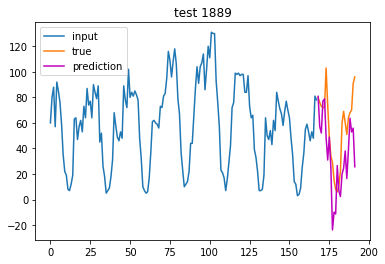

In [12]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=123)
pred = model.predict(test_x)
pred = inverse_norm(pred.T, scaler=scaler_test).T
for i in np.random.randint(0, test_x.shape[0], 50):
    plt.figure()
    plt.plot(range(train_size), test_x_original[i], label='input')
    plt.plot(range(train_size, train_size+test_size), test_y_original[i], label='true')
    plt.plot(range(train_size, train_size+test_size), pred[i], c='m', label='prediction')
    plt.title(f'test {i}')
    plt.legend()

In [15]:
import pickle

benchmark = {'test_x': test_x, 
             'test_y_original': test_y_original,
             'test_x_original': test_x_original,
             'scaler_benchmark': scaler_test}
with open('v1-col-11.pkl', 'wb') as handle:
    pickle.dump(benchmark , handle, protocol=pickle.HIGHEST_PROTOCOL)